# Basic engine implementation

#### setup

In [27]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image
import scipy.signal as sig

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
video_location = dataset_location + specific_dir + seperator + "test.mp4"


[2021-03-12 17:13:06,971] [INFO] [<module>] [13] : Starting ...


#### Detecting the face landmarks and parsing the ROI

In [28]:
def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    # iterate through all the faces.
    for face_location in face_locations:
#         img = PIL.Image.open(frame)
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.2) # 30 percent of the face len (toadd eyebrow top point).
        # Finding the forehead.
        right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom)) # adding diff to top to make the forehead bigger.

        # Finding the second ROI:
        upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))
#         try:
#             concat_roi_areas = np.concatenate((forehead, nose_to_upper_lip), axis=0)
#             cv2.imwrite('frame_roi_output.jpg', concat_roi_areas)
        return (forehead, nose_to_upper_lip)
#         except:
#             logging.warning("concat of roi areas failed")
#             return None
    return None # in case of which no face was detected

In [29]:
#R > 95 and G > 40 and B > 20 and R > G and R > B
# based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5
def bad_frame(blue, green, red):
    if red > 95 and green > 40 and blue > 20 and red >green and red > blue:
        return False
    logging.warning("bad frame detected")
    return True

#### Getting RGB values from a frame and adding them to arrays

In [30]:
def parse_RGB(image, greens, reds, blues, frame_number):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
    im = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    blue, green, red = cv2.split(im)
    if not bad_frame(np.mean(blue), np.mean(green), np.mean(red)):
        greens[0, frame_number] = np.mean(green)
        blues[0, frame_number] = np.mean(blue)
        reds[0, frame_number] = np.mean(red)
        return True
    return False

In [31]:
def get_new_frame(vidcap):
    success, image = vidcap.read()
    return success, image

#### Plotting RGB arrays results

In [32]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    x_value = x_value.reshape(1, x_value.shape[0])
    r = reds.tolist()[0]
    b = blues.tolist()[0]
    g = greens.tolist()[0]
    x = x_value.tolist()[0]
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x, g, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x, r, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x, b, color="blue")
    plt.show()
    logging.info("Showing result")


#### Filtering:

In [33]:
def filter_channel(channel,fs):
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    channel = sig.filtfilt(bh, ah, channel)
    channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel)
    return channel_after_filter

#### Main loop - going over all the frames of the video

[2021-03-12 17:13:07,037] [INFO] [<module>] [1] : Working on video ../dataset/good_sync/perry-all-2/test.mp4
[2021-03-12 17:13:07,066] [INFO] [<module>] [11] : Parsing images ...
[2021-03-12 17:13:07,067] [INFO] [<module>] [13] : parsing frame 0/179.0
[2021-03-12 17:13:07,447] [INFO] [<module>] [13] : parsing frame 1/179.0
[2021-03-12 17:13:07,822] [INFO] [<module>] [13] : parsing frame 2/179.0
[2021-03-12 17:13:08,187] [INFO] [<module>] [13] : parsing frame 3/179.0
[2021-03-12 17:13:08,550] [INFO] [<module>] [13] : parsing frame 4/179.0
[2021-03-12 17:13:08,908] [INFO] [<module>] [13] : parsing frame 5/179.0
[2021-03-12 17:13:09,270] [INFO] [<module>] [13] : parsing frame 6/179.0
[2021-03-12 17:13:09,633] [INFO] [<module>] [13] : parsing frame 7/179.0
[2021-03-12 17:13:09,987] [INFO] [<module>] [13] : parsing frame 8/179.0
[2021-03-12 17:13:10,341] [INFO] [<module>] [13] : parsing frame 9/179.0
[2021-03-12 17:13:10,693] [INFO] [<module>] [13] : parsing frame 10/179.0
[2021-03-12 17:13

[2021-03-12 17:13:47,997] [INFO] [<module>] [13] : parsing frame 109/179.0
[2021-03-12 17:13:48,380] [INFO] [<module>] [13] : parsing frame 110/179.0
[2021-03-12 17:13:48,761] [INFO] [<module>] [13] : parsing frame 111/179.0
[2021-03-12 17:13:49,145] [INFO] [<module>] [13] : parsing frame 112/179.0
[2021-03-12 17:13:49,516] [INFO] [<module>] [13] : parsing frame 113/179.0
[2021-03-12 17:13:49,885] [INFO] [<module>] [13] : parsing frame 114/179.0
[2021-03-12 17:13:50,255] [INFO] [<module>] [13] : parsing frame 115/179.0
[2021-03-12 17:13:50,631] [INFO] [<module>] [13] : parsing frame 116/179.0
[2021-03-12 17:13:50,999] [INFO] [<module>] [13] : parsing frame 117/179.0
[2021-03-12 17:13:51,368] [INFO] [<module>] [13] : parsing frame 118/179.0
[2021-03-12 17:13:51,737] [INFO] [<module>] [13] : parsing frame 119/179.0
[2021-03-12 17:13:52,109] [INFO] [<module>] [13] : parsing frame 120/179.0
[2021-03-12 17:13:52,488] [INFO] [<module>] [13] : parsing frame 121/179.0
[2021-03-12 17:13:52,870]

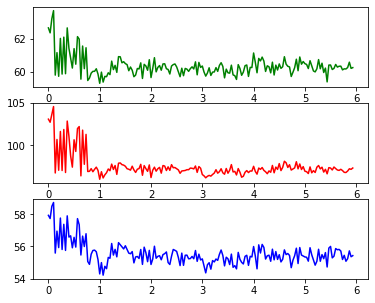

[2021-03-12 17:14:14,994] [INFO] [plot_result] [19] : Showing result
[2021-03-12 17:14:14,998] [INFO] [plot_result] [2] : Plotting results ...After Filter


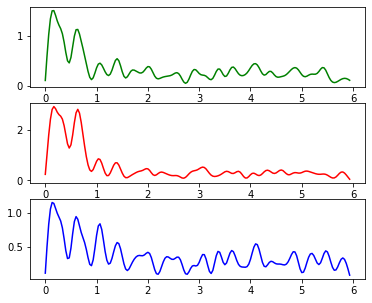

[2021-03-12 17:14:15,224] [INFO] [plot_result] [19] : Showing result


In [34]:

logging.info("Working on video " + video_location)
vidcap = cv2.VideoCapture(video_location)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
x_value = np.arange((number_of_frames / np.round(fps)), step=(1 / 30))
greens = np.zeros((1, int(number_of_frames)))  # instead of lists
reds = np.zeros((1, int(number_of_frames)))
blues = np.zeros((1, int(number_of_frames)))
frame_number = 0
logging.info("Parsing images ...")
while success:
    logging.info("parsing frame " + str(frame_number) + "/" + str(number_of_frames))
    # im.save("your_file.jpeg")
    roi = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI
    if roi != None: 
#     image = cv2.imread("frame_roi_output.jpg") # possible BUG: read the same image twice if face not detected.
        is_good_frame = parse_RGB(np.vstack((roi[0],roi[1])), greens, reds, blues, frame_number)
    success, image = get_new_frame(vidcap)
    if is_good_frame:
        frame_number += 1
plot_result(greens, reds, blues, x_value, "All 3 channels") # original signals


green_buttered = filter_channel(greens,fps)
red_buttered = filter_channel(reds,fps)
blue_buttered = filter_channel(blues,fps)


plot_result(green_buttered, red_buttered, blue_buttered, x_value, "After Filter") # after filtering




### PSD estimation using 'Welch' or 'Periodogram'

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 1024 is greater than input length  = 179, using nperseg = 179
  warnings.warn('nperseg = {0:d} is greater than input length '


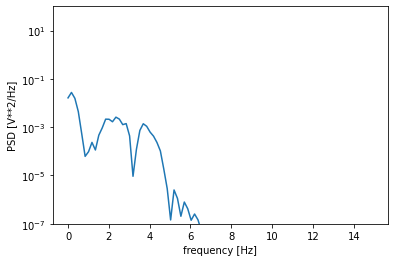

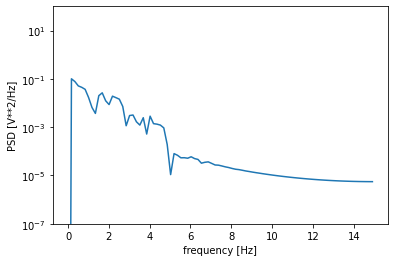

In [35]:
f, Pxx_den = sig.welch(green_buttered.tolist()[0], fps,'flattop', 1024, scaling='spectrum')
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

f, Pxx_den = sig.periodogram(green_buttered.tolist()[0], fps)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()